## Boundary Layer Model - V02

Comparison with SAR data

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

import warnings
warnings.filterwarnings("ignore")

In [2]:
PTHS = {
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/11_BL_v02_comp_wSAR/'
}

In [3]:
####-----------####
#### FUNCTIONS ####
####-----------####

### MODEL
def coriolis(lat):
    '''Absolute vorticity.
    Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat, vmin=0):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def willoughby_profile_no_smooth(r, n, X1, Vmin, Rmax, Vmax):
    '''No polynomial ramp smoothing here.
    We assume V(0) = Vmin != 0 to fit SAR data'''
    V    = r * 0.
    Vinf = (Vmax - Vmin) * ((r / Rmax) ** n) + Vmin
    Vsup = (Vmax - Vmin) * np.exp((-1.) * ((r - Rmax) / X1)) + Vmin
    V[r <=Rmax] = Vinf[r <=Rmax]
    V[r > Rmax] = Vsup[r > Rmax]
    return V

In [4]:
# Inertial stability
def I(r, v, fcor):
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * v / r + fcor
    zeta = np.gradient(v, dr) + v / r + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(r, V, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * V / r + fcor
    zeta = np.gradient(V, dr) + V / r + fcor
    return np.sqrt(ksi / zeta)

def eta(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / (K * ((V / r) + I(r, V, fcor))))

def ki(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / (K * I(r, V, fcor)))

def psi(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / abs(K * ((V / r) - I(r, V, fcor))))

# Amplitudes
def A0(r, V, K, C, fcor):
    num = -ki(r, V, K, C, fcor) * V * [1 + 1j * (1 + ki(r, V, K, C, fcor))]
    den = 2 * ki(r, V, K, C, fcor) ** 2 + 3 * ki(r, V, K, C, fcor) + 2
    return num / den

def A1(r, V, Ut, K, C, fcor):
    num = -eta(r, V, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(r, V, fcor)) * psi(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [(2 + 2j) * (1 + eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)) + 3 * eta(r, V, K, C, fcor) + 3j * psi(r, V, K, C, fcor)]
    return num / den

def A_1(r, V, Ut, K, C, fcor):
    num = -psi(r, V, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(r, V, fcor)) * eta(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [(2 + 2j) * (1 + eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)) + 3 * psi(r, V, K, C, fcor) + 3j * eta(r, V, K, C, fcor)]
    return num / den

def A1_prime(r, V, Ut, K, C, fcor):
    num = -eta(r, V, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(r, V, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(r, V, fcor)) * psi(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [2 + 2j + 3 * (eta(r, V, K, C, fcor) + psi(r, V, K, C, fcor)) + (2 - 2j) * eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)]
    return num / den

def A_1_prime(r, V, Ut, K, C, fcor):
    num = -psi(r, V, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(r, V, fcor)) * eta(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [2 - 2j + 3 * (eta(r, V, K, C, fcor) + psi(r, V, K, C, fcor)) + (2 + 2j) * eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)]
    return num / den

# Radial and tangential wind components at the surface (z = 0)
def u0(r, V, K, C, fcor):
    return np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A0(r, V, K, C, fcor)))

def v0(r, V, K, C, fcor):
    return np.squeeze(np.imag(A0(r, V, K, C, fcor)))

def u1(theta, r, V, Ut, K, C, fcor):
    u1        = V * 0
    msk       = I(r, V, fcor) >= V / r
    u1[msk]   = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))[msk]
    u1[~msk]  = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))[~msk]
    return u1

def v1(theta, r, V, Ut, K, C, fcor):
    v1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    v1[msk] = np.squeeze(np.imag(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))[msk]
    v1[~msk]= np.squeeze(np.imag(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))[~msk]
    return v1

def u_1(theta, r, V, Ut, K, C, fcor):
    u1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    u1[msk] = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))[msk]
    u1[~msk]= np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))[~msk]
    return u1

def v_1(theta, r, V, Ut, K, C, fcor):
    v1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    v1[msk] = np.squeeze(np.imag(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))[msk]
    v1[~msk]= np.squeeze(np.imag(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(theta, r, V, Ut, K, C, fcor):
    return u_1(theta, r, V, Ut, K, C, fcor) + u0(r, V, K, C, fcor) + u1(theta, r, V, Ut, K, C, fcor)

def v_BL(theta, r, V, Ut, K, C, fcor):
    return V + v_1(theta, r, V, Ut, K, C, fcor) + v0(r, V, K, C, fcor) + v1(theta, r, V, Ut, K, C, fcor)

In [5]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def get_V_tot_BL(vmx, rmx, B, lat, Ut, vmn=0, K=50, C=2.5e-3):
    # Initialize grids
    rs      = np.linspace(10, 8e5, 800)
    ths     = np.linspace(0, 2 * np.pi, 361)
    Rs, THs = np.meshgrid(rs, ths)
    Us      = np.ones_like(Rs)
    Vs      = np.ones_like(Rs)
    
    # Compute V holland
    V = h80(rs, vmx, rmx, B, lat, vmn)
    
    # Assign surface winds inside BL
    for i, th in enumerate(ths):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, coriolis(lat))
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, coriolis(lat))
        
    # Add storm speed vector
    Us       = Us + Ut * np.cos(THs)
    Vs       = Vs - Ut * np.sin(THs)
    
    # Compute total BL wind
    V_tot_BL = np.sqrt(Vs ** 2 + Us ** 2)
    
    # Define cartesian grids 
    Xs, Ys   = pol2cart(Rs, THs + np.pi/2)
    
    return V_tot_BL, Xs, Ys

def get_V_tot_BL_will(n, X1, vmn, rmx, vmx, lat, Ut, K=50, C=2.5e-3):
    # Initialize grids
    rs      = np.linspace(10, 8e5, 800)
    ths     = np.linspace(0, 2 * np.pi, 361)
    Rs, THs = np.meshgrid(rs, ths)
    Us      = np.ones_like(Rs)
    Vs      = np.ones_like(Rs)
    
    # Compute V will
    V = willoughby_profile_no_smooth(rs / 1000, n, X1, vmn, rmx, vmx)
    
    # Assign surface winds inside BL
    for i, th in enumerate(ths):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, coriolis(lat))
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, coriolis(lat))
        
    # Add storm speed vector
    Us       = Us + Ut * np.cos(THs)
    Vs       = Vs - Ut * np.sin(THs)
    
    # Compute total BL wind
    V_tot_BL = np.sqrt(Vs ** 2 + Us ** 2)
    
    # Define cartesian grids 
    Xs, Ys   = pol2cart(Rs, THs + np.pi/2)
    
    return V_tot_BL, Xs, Ys

def std_prof(V):
    return np.std(V / np.nanmax(V), axis=0)

In [6]:
### OPEN SAR DATA
dsg  = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc')
dsg2 = xr.open_dataset('/home/arthur/results/TCsLifeMonitFromObs/07_SAR_K10/ds_glob.nc')
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)

In [7]:
# rs   = np.linspace(10, 8e5, 800)
# vmx  = 50
# rmx  = 50000
# B    = 1.5
# lat  = 20
# Ut   = 5     # Translation speed

# V_tot, Xs, Ys = get_V_tot_BL(vmx, rmx, B, lat, Ut)

In [8]:
# plt.pcolormesh(Xs, Ys, V_tot, cmap=cm.get_cmap('jet', 30));plt.colorbar()
# plt.grid();plt.xlim(-5e5, 5e5);plt.ylim(-5e5, 5e5)

In [9]:
# Bs     = [1, 1.5, 2, 2.5]
# colors = mpl.cm.coolwarm(np.linspace(0, 1, len(Bs)))

# for i, b in tqdm(enumerate(Bs)):
#     V_tot, Xs, Ys = get_V_tot_BL(vmx, rmx, b, lat, Ut)
#     plt.plot(rs, std_prof(V_tot), c=colors[i], label='B = {}'.format(b))
# plt.grid();plt.legend()

In [10]:
# ds = dsg.isel(time=0)
# R_SAR, TH_SAR = np.meshgrid(ds.rad, np.pi / 2 - np.deg2rad(ds.theta))
# X_SAR, Y_SAR  = pol2cart(R_SAR, TH_SAR)

# vmx_sar = float(ds.Vmax_1D)
# rmx_sar = float(ds.Rmax_1D * 1000)
# B_sar   = float(ds.B_hol)
# lat_sar = float(abs(ds.lat_center))
# Ut_sar  = float(ds.cyclone_speed)

# V_tot, Xs, Ys = get_V_tot_BL(vmx_sar, rmx_sar, B_sar / 2, lat_sar, Ut_sar)

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# # SAR
# axs[0].set_title('SAR', weight='bold')
# divider = make_axes_locatable(axs[0])
# cax     = divider.append_axes('right', size='5%', pad=0.05)
# im      = axs[0].pcolormesh(X_SAR / 1000, Y_SAR / 1000, ds.wind_speed.transpose(), cmap=cm.get_cmap('jet', 12), vmin=10, vmax=vmx_sar * 1.1)
# fig.colorbar(im, cax=cax, orientation='vertical')
# axs[0].grid();axs[0].set_xlim(-200, 200);axs[0].set_ylim(-200, 200)

# # K01
# axs[1].set_title('MODEL - K01', weight='bold')
# divider = make_axes_locatable(axs[1])
# cax     = divider.append_axes('right', size='5%', pad=0.05)
# im      = axs[1].pcolormesh(Xs / 1000, Ys / 1000, V_tot, cmap=cm.get_cmap('jet', 12), vmin=10, vmax=vmx_sar * 1.1)
# fig.colorbar(im, cax=cax, orientation='vertical')
# axs[1].grid();axs[1].set_xlim(-200, 200);axs[1].set_ylim(-200, 200)

In [11]:
# plt.plot(rs, h80(rs, vmx_sar, rmx_sar, B_sar, lat_sar, vmin=0))
# plt.plot(rs, h80(rs, vmx_sar - vmn_sar, rmx_sar, B_sar, lat_sar, vmin=vmn_sar))

  0%|          | 0/10 [00:00<?, ?it/s]

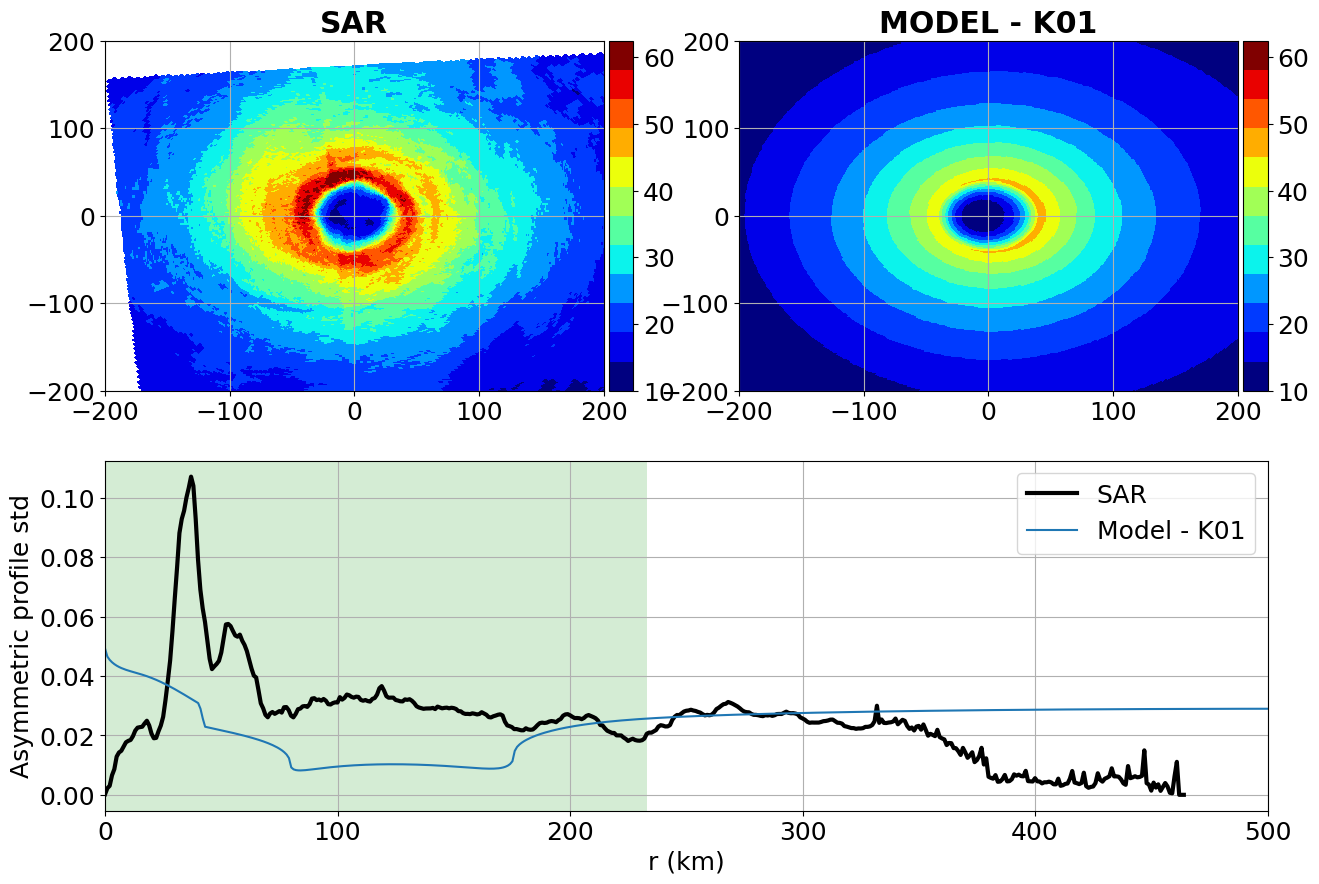

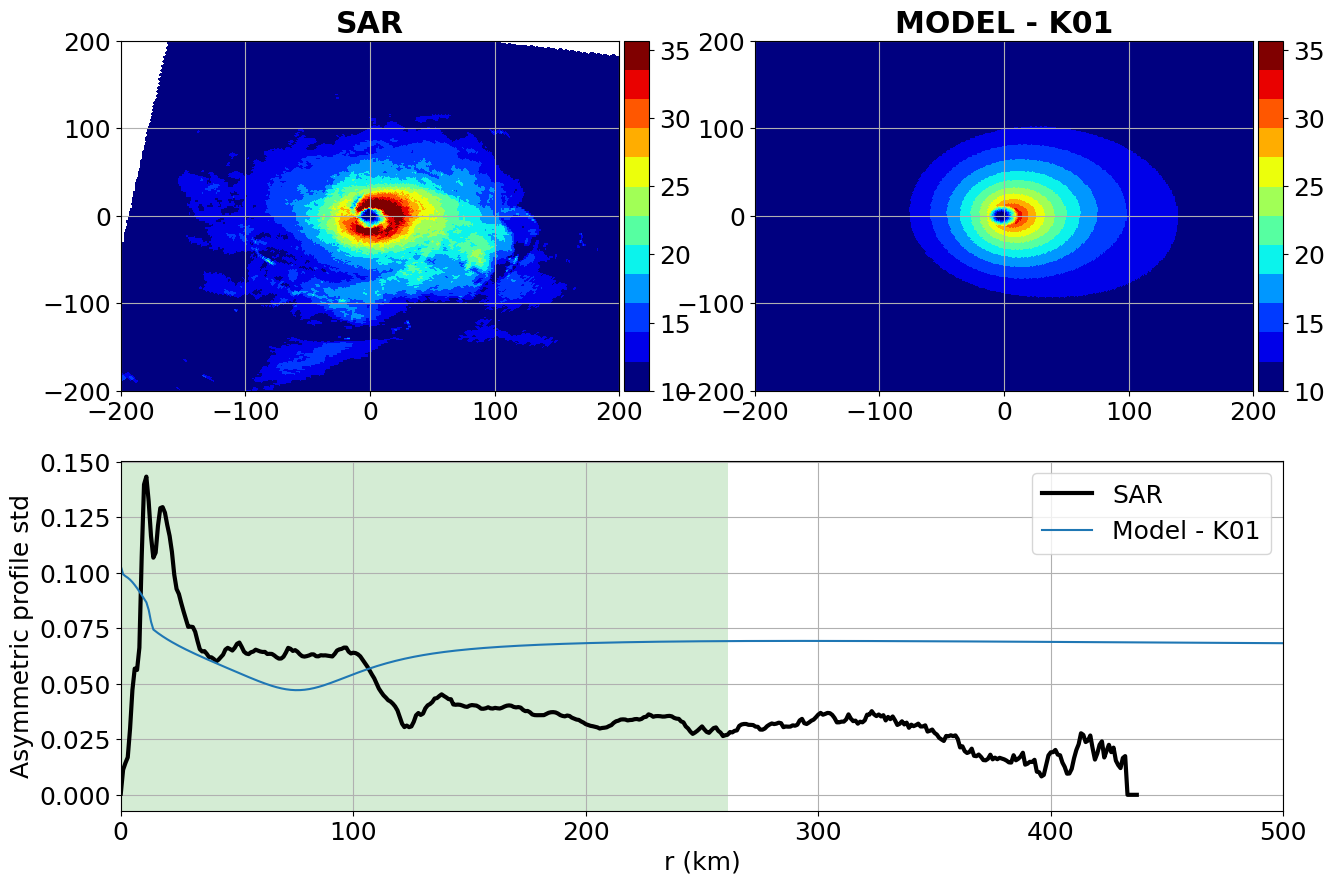

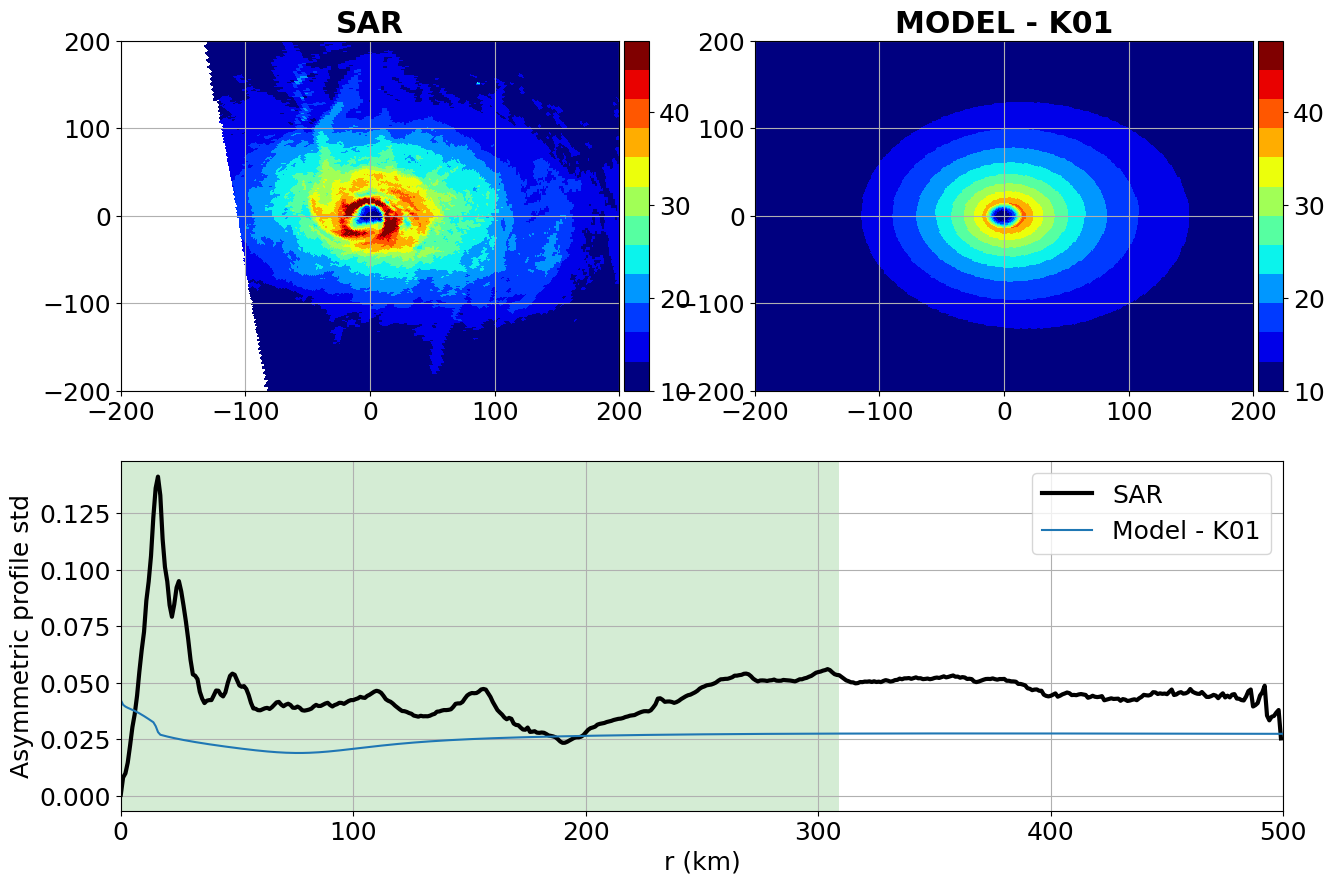

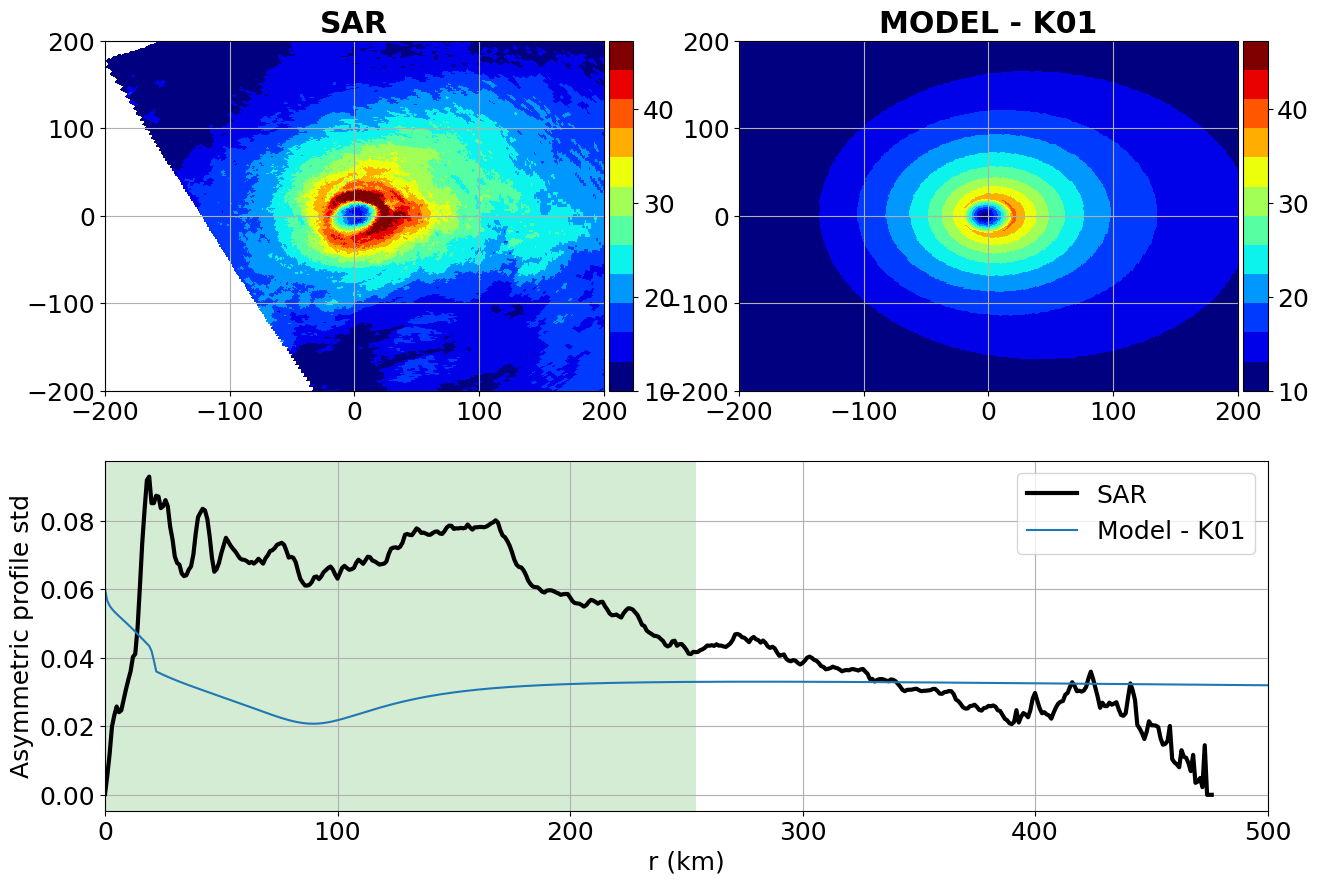

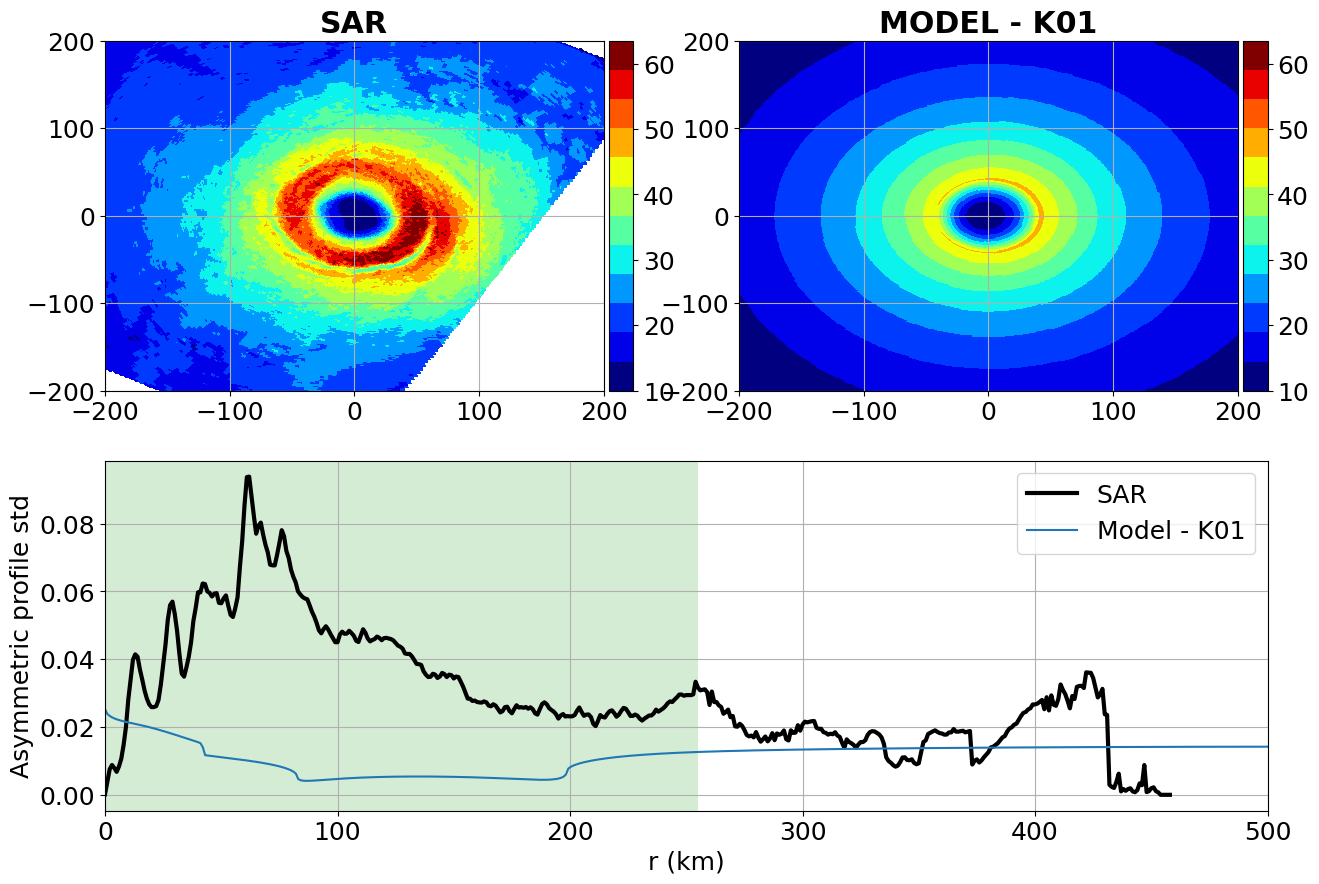

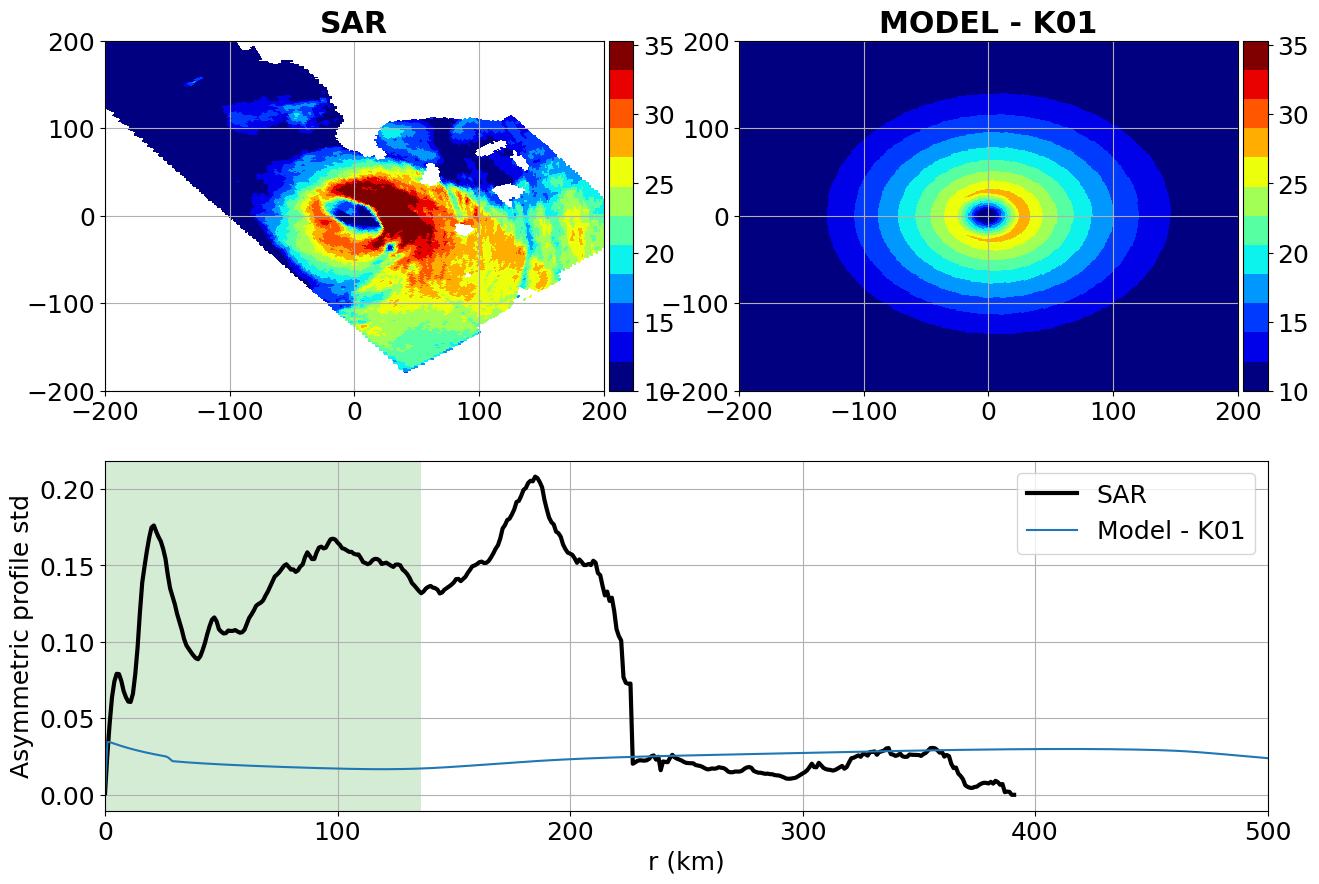

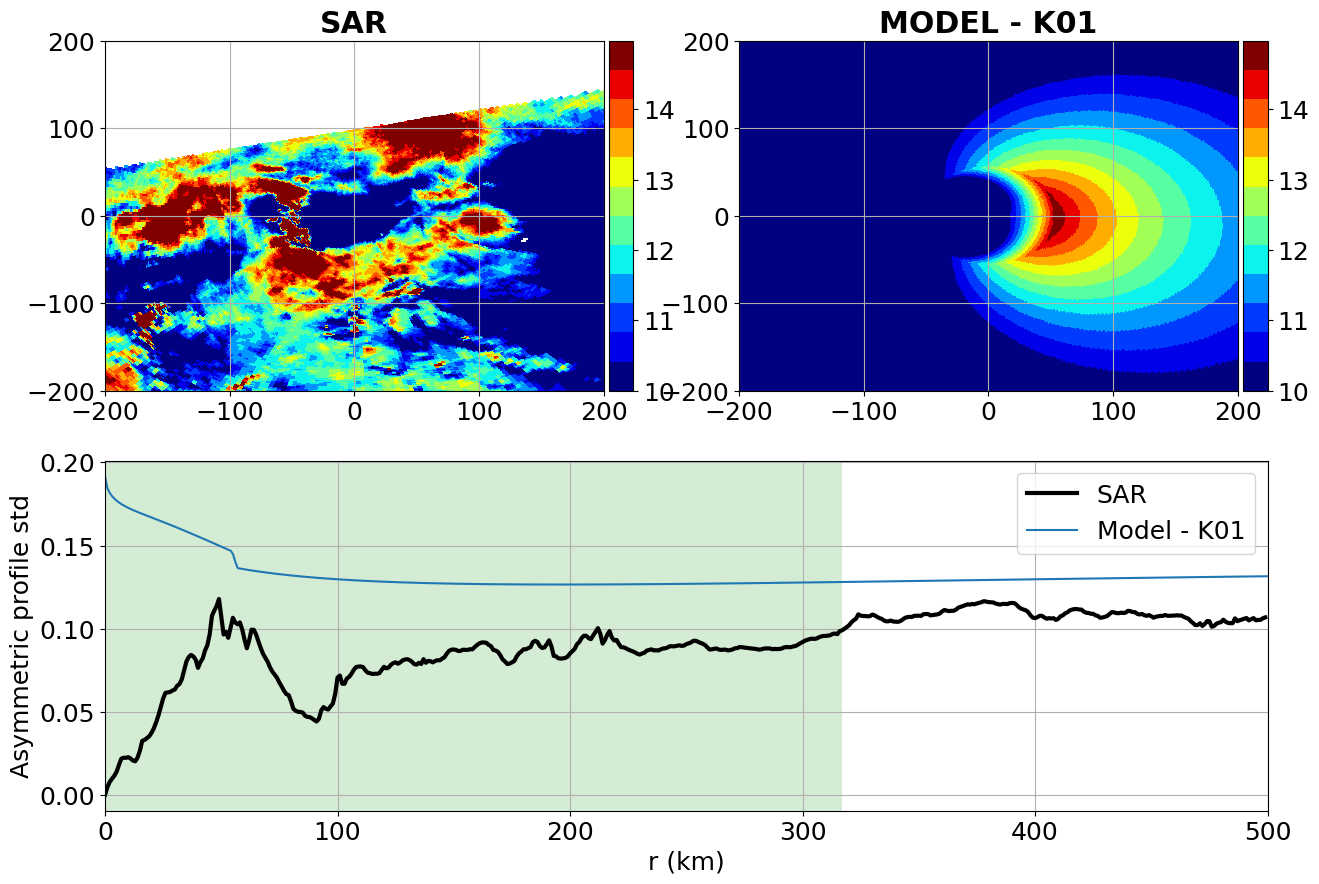

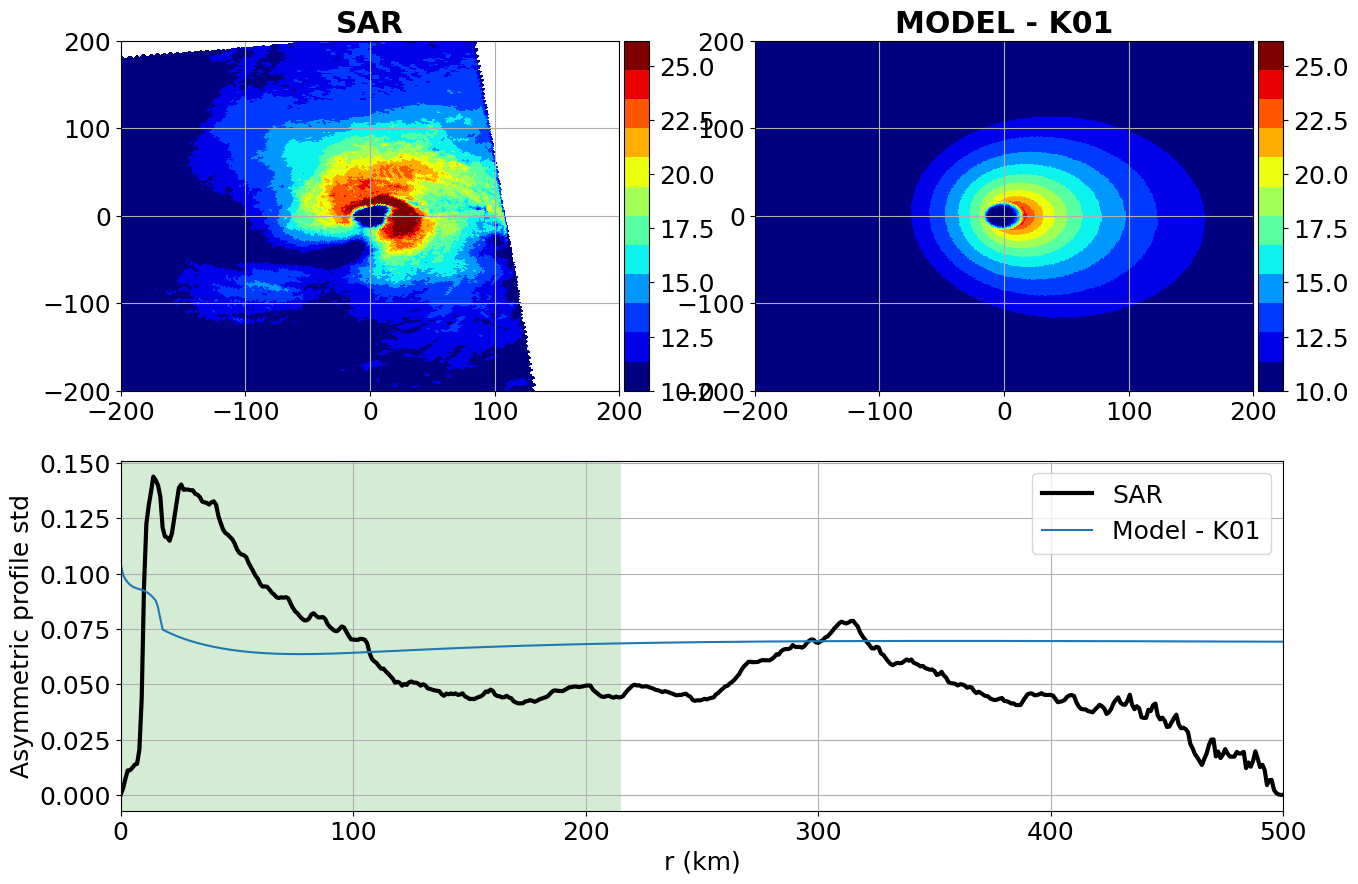

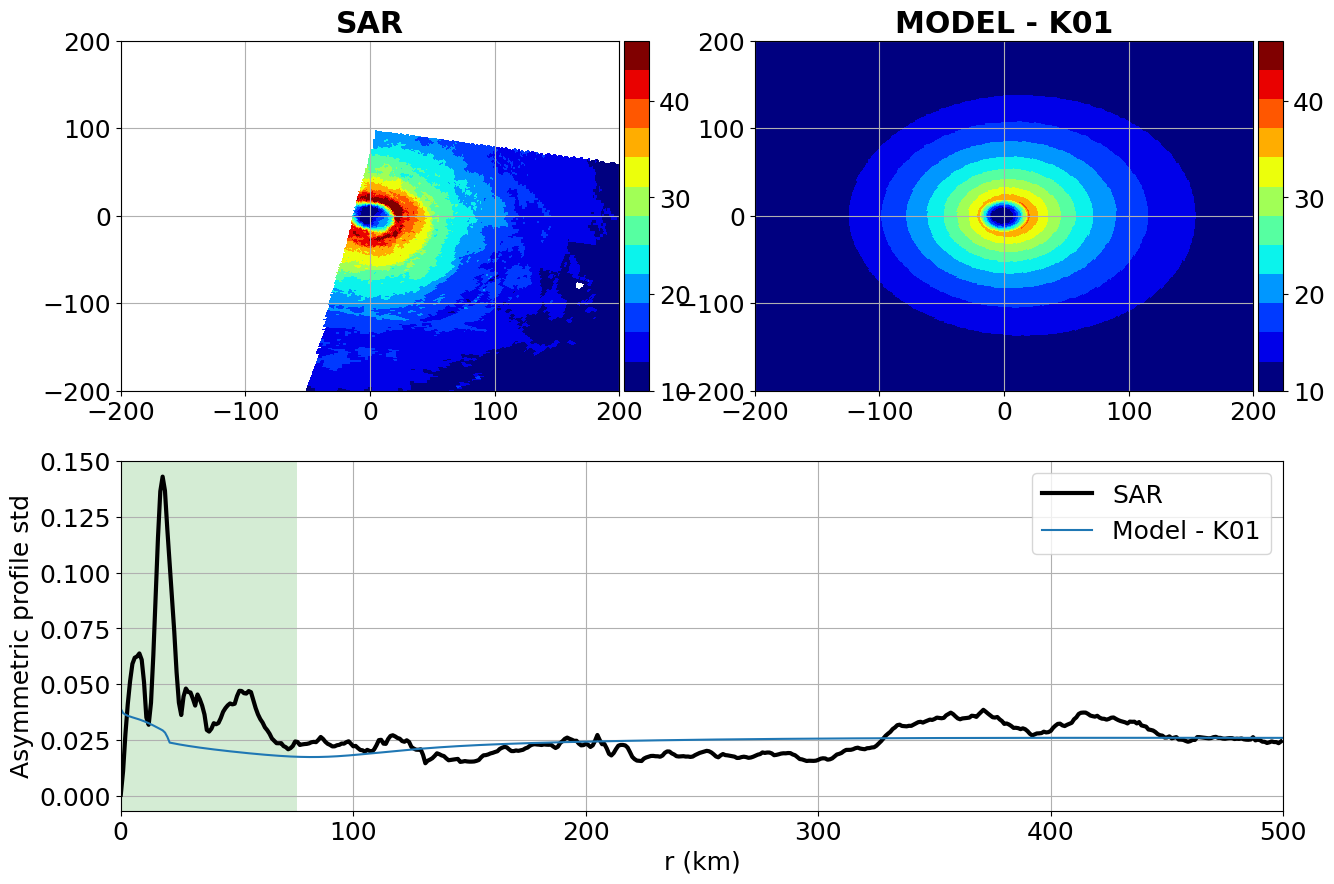

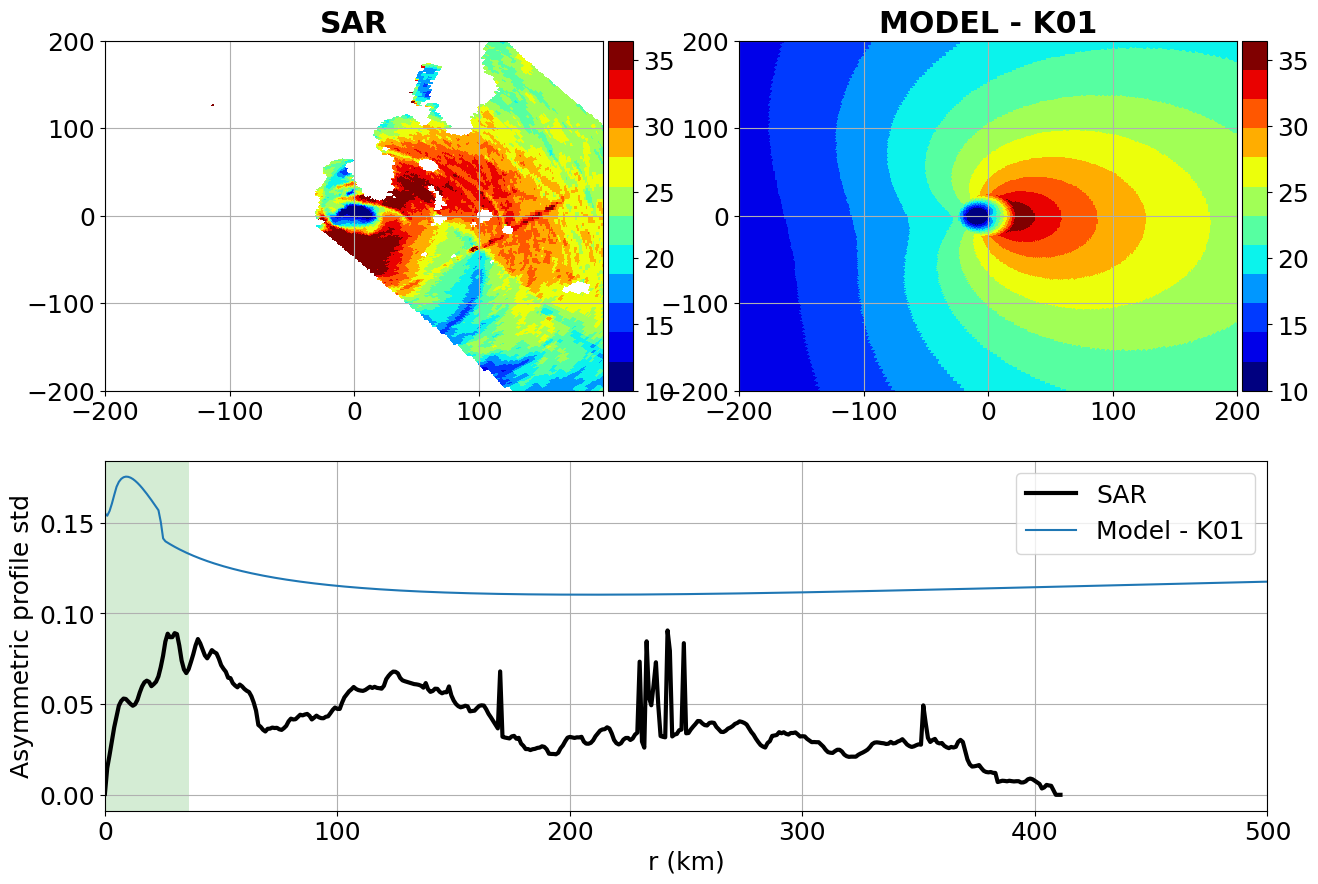

In [38]:
for t in tqdm(range(len(dsg.time))[:10]):
    ds            = dsg.isel(time=t)
    R_SAR, TH_SAR = np.meshgrid(ds.rad, np.pi / 2 - np.deg2rad(ds.theta))
    X_SAR, Y_SAR  = pol2cart(R_SAR, TH_SAR)

    # # Holland version
    # vmx_sar = float(ds.Vmax_1D)
    # rmx_sar = float(ds.Rmax_1D * 1000)
    # B_sar   = float(ds.B_hol)
    # lat_sar = float(abs(ds.lat_center))
    # Ut_sar  = float(ds.cyclone_speed)
    # vmn_sar = float(ds.Vmin2_fit)
    # V_tot, Xs, Ys = get_V_tot_BL(vmx_sar, rmx_sar, np.sqrt(B_sar), lat_sar, Ut_sar)
    # # V_tot, Xs, Ys = get_V_tot_BL(vmx_sar - vmn_sar, rmx_sar, B_sar, lat_sar, Ut_sar, vmn=vmn_sar)
    
    # Willoughby version
    n_sar   = float(ds.n_will)
    X1_sar  = float(ds.X1_will)
    vmn_sar = float(ds.Vmin_will)
    rmx_sar = float(ds.Rmax_will)
    vmx_sar = float(ds.Vmax_will)
    lat_sar = float(abs(ds.lat_center))
    Ut_sar  = float(ds.cyclone_speed)
    V_tot, Xs, Ys = get_V_tot_BL_will(n_sar, X1_sar, vmn_sar, rmx_sar, vmx_sar, lat_sar, Ut_sar)    
    B_sar   = float(ds.B_hol)

    # Plot
    # fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    fig = plt.figure()
    gs  = fig.add_gridspec(2,2)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, :])]

    # SAR
    axs[0].set_title('SAR', weight='bold')
    divider = make_axes_locatable(axs[0])
    cax     = divider.append_axes('right', size='5%', pad=0.05)
    im      = axs[0].pcolormesh(X_SAR / 1000, Y_SAR / 1000, ds.wind_speed.transpose(), cmap=cm.get_cmap('jet', 12), vmin=10, vmax=vmx_sar * 1.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[0].grid();axs[0].set_xlim(-200, 200);axs[0].set_ylim(-200, 200)

    # K01
    axs[1].set_title('MODEL - K01', weight='bold')
    divider = make_axes_locatable(axs[1])
    cax     = divider.append_axes('right', size='5%', pad=0.05)
    im      = axs[1].pcolormesh(Xs / 1000, Ys / 1000, V_tot, cmap=cm.get_cmap('jet', 12), vmin=10, vmax=vmx_sar * 1.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[1].grid();axs[1].set_xlim(-200, 200);axs[1].set_ylim(-200, 200)
    
    # print('Vmax = {:.1f} m/s, Rmax = {:.0f} km, lat = {:.1f}°'.format(vmx_sar, rmx_sar / 1000, lat_sar))
    # print('B = {:.1f}, Ut = {:.1f} m/s'.format(B_sar, Ut_sar))
    
    # Asymmetries
    rs           = np.linspace(10, 8e5, 800)
    std_prof_k01 = std_prof(V_tot)
    std_prof_sar = (ds.wind_speed / ds.wind_speed.max(dim=['rad', 'theta'])).std(dim='theta', skipna=True)
    axs[2].plot(std_prof_sar.rad / 1000, std_prof_sar, c='k', linewidth=3, label='SAR')
    axs[2].plot(rs / 1000, std_prof_k01, c='tab:blue', label='Model - K01')
    axs[2].set_xlim(0, 500);axs[2].legend();axs[2].grid()
    axs[2].set_xlabel('r (km)');axs[2].set_ylabel('Asymmetric profile std')
    
    valids = ds.where(ds.wind_speed.notnull().sum(dim='theta') > 200, drop=True)
    if len(valids.rad) > 2:
        axs[2].axvspan(valids.rad[0] / 1000, valids.rad[-1] / 1000, facecolor='tab:green', alpha=0.2, label='Valid area')
    
    plt.show()
    # plt.savefig(PTHS['sav_dir'] + ds.sat_file.item().split('.')[0]);plt.clf()